In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/classicRec.png
/kaggle/input/book-recommendation-dataset/Books.csv
/kaggle/input/book-recommendation-dataset/DeepRec.png
/kaggle/input/book-recommendation-dataset/recsys_taxonomy2.png
/kaggle/input/otto-full-optimized-memory-footprint/id2type.pkl
/kaggle/input/otto-full-optimized-memory-footprint/train.parquet
/kaggle/input/otto-full-optimized-memory-footprint/type2id.pkl
/kaggle/input/otto-full-optimized-memory-footprint/test.parquet
/kaggle/input/otto-recommender-system/sample_submission.csv
/kaggle/input/otto-recommender-system/test.jsonl
/kaggle/input/otto-recommender-system/train.jsonl


In [69]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

In [70]:
df_book = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
df_rating = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')
df_user = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')

In [71]:
df_book.shape, df_rating.shape,df_user.shape

((271360, 8), (1149780, 3), (278858, 3))

# Problem phrasing

* Based on the datasets provided, we will rely on closest neighborhood which is base on users' similarity to provide recommendation on new books
* Objective: predict top 5 popular book for each individual
* Performance measurement: if we have a perfect dataset in which everyone read the same books, then we can conduct cross-validation for hold-out books
     

# 1. Data preparation

In [72]:
# Dataset merge and treat missing, zero and extreme value
df_rating_user = pd.merge(df_rating,df_user,on = 'User-ID', how = 'left')
df_overall = pd.merge(df_rating_user,df_book,on = 'ISBN',how='left')

df_overall_v1 = df_overall.dropna()

age_cap = df_overall_v1['Age'].quantile(0.99)
df_overall_vf = df_overall_v1[df_overall_v1['Age']<= age_cap]

df_overall_vf['loc_ctry'] = df_overall_vf['Location'].str.rsplit(',', n=1).str[-1]

# KNN model treatment - numerical variables
min = df_overall_vf['Age'].min()
max = df_overall_vf['Age'].max()
df_overall_vf['Age_var'] = (df_overall_vf['Age']-min)/(max - min)

# KNN model treatment - categorical variables
from sklearn.preprocessing import OneHotEncoder
X_encoder = OneHotEncoder(drop = 'first',sparse_output = False)
X_encoded = X_encoder.fit_transform(df_overall_vf[['loc_ctry']])
loc_name = [col + '_var' for col in X_encoder.get_feature_names_out()]

X_encoded = pd.DataFrame(data=X_encoded,columns = loc_name)
df_overall_vf_v = df_overall_vf.reset_index() #for the purpose of pd.concat
df_overall_vf_v = pd.concat([df_overall_vf_v,X_encoded], axis = 1)
df_overall_vf_v.head(2)

,index,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,...,loc_ctry_ usa & canada_var,loc_ctry_ uzbekistan_var,loc_ctry_ venezuela_var,loc_ctry_ vietnam_var,loc_ctry_ wales_var,loc_ctry_ ysa_var,loc_ctry_ yugoslavia_var,loc_ctry_ zambia_var,loc_ctry_ zimbabwe_var,"loc_ctry_""_var"
0,2,276727,0446520802,0,"h, new south wales, australia",16.0,The Notebook,Nicholas Sparks,1996,Warner Books,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
var_model = df_overall_vf_v.filter(like = '_var').columns
df_user_knn = df_overall_vf_v[var_model]
df_user_knn = pd.concat([df_overall_vf_v['User-ID'],df_user_knn],axis =1)

In [74]:
df_user_knn_v1 = df_user_knn.drop_duplicates()
df_user_knn_vf = df_user_knn_v1.drop(columns = 'User-ID')

# 2. Data Feature Understanding

Given we plan to use users' age and location as dimension for similary,we use top2 popular book to demonstrate if there is homogeneity exsit based on these two features, and heterogeneity exist across the range of these two features

In [75]:
rating_summary = df_overall_vf.groupby('ISBN')['Book-Rating'].agg(['count']).reset_index()
rating_summary_sort = rating_summary.sort_values(by ='count', ascending = False).head(2)
top_rated_book = pd.merge(rating_summary_sort,df_book, on = 'ISBN', how = 'left')
top_rated_book

,ISBN,count,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0971880107,2113,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,912,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...


In [76]:
# pull ratings for top 2 books to see if there is strong evidence that age and location determine the rating
df_overall_vf['age_bin'] = pd.qcut(df_overall_vf['Age'],10,labels = False)

df_rating_top1book = df_overall_vf[df_overall_vf['ISBN'] == '0971880107']
df_rating_top2book = df_overall_vf[df_overall_vf['ISBN'] == '0316666343']

<Axes: xlabel='Book-Rating', ylabel='Count'>

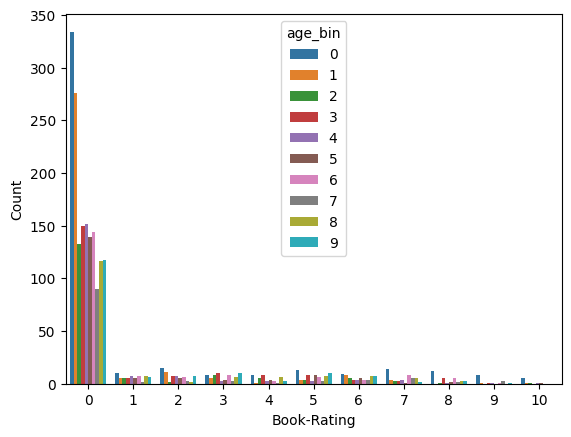

In [77]:
summary = df_rating_top1book.groupby(['Book-Rating','age_bin'])['Age'].count().reset_index().rename(columns = {"Age": "Count"})
sns.barplot(summary, x = 'Book-Rating', y = 'Count', hue = 'age_bin')

In [78]:
df_rating_top1book.groupby('loc_ctry')['Book-Rating'].agg(['count','mean','var','min','max']).reset_index().sort_values(by = 'count', ascending = False).head(10)

,loc_ctry,count,mean,var,min,max
59,usa,1004,1.021912,4.839001,0,10
8,canada,184,0.978261,4.666191,0,10
2,australia,183,1.120219,4.842611,0,9
58,united kingdom,179,0.748603,3.560040,0,9
17,germany,119,0.899160,4.854152,0,10
53,spain,67,0.567164,2.946178,0,7
46,portugal,45,0.288889,1.573737,0,6
38,new zealand,36,1.166667,3.914286,0,6
16,france,34,0.147059,0.371658,0,3
33,malaysia,21,0.571429,2.357143,0,5


<Axes: xlabel='Book-Rating', ylabel='Count'>

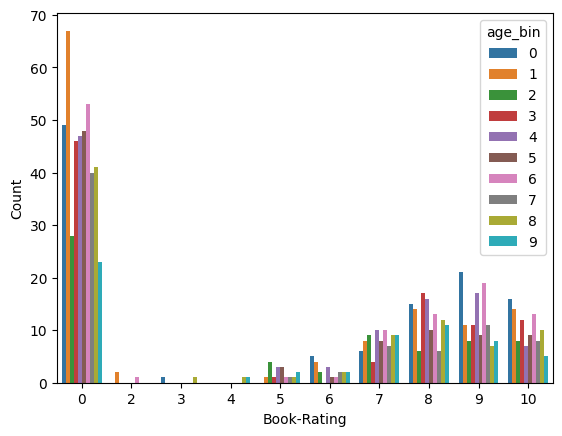

In [79]:
summary = df_rating_top2book.groupby(['Book-Rating','age_bin'])['Age'].count().reset_index().rename(columns = {"Age": "Count"})
sns.barplot(summary, x = 'Book-Rating', y = 'Count', hue = 'age_bin')

In [80]:
df_rating_top2book.groupby('loc_ctry')['Book-Rating'].agg(['count','mean','var','min','max']).reset_index().sort_values(by = 'count', ascending = False).head(10)

,loc_ctry,count,mean,var,min,max
23,usa,652,4.305215,18.037269,0,10
4,canada,85,4.600000,18.719048,0,10
22,united kingdom,28,4.071429,18.068783,0,10
0,,27,6.222222,16.025641,0,10
13,netherlands,17,3.294118,16.970588,0,10
9,germany,15,3.533333,20.552381,0,10
1,australia,14,3.500000,15.653846,0,9
11,italy,12,1.166667,7.424242,0,7
19,spain,11,4.090909,16.090909,0,9
16,portugal,11,3.727273,18.618182,0,9


# 3. Create a recommendation book list for one top reader as a demo

Assuming there is homogeneity exist based on reader's profile, we first test out to create a recommendation book list based on the closest neighborhood for one top rater before apply to overall population.

In [81]:
# create a datasets for top 500 rater only,on avg they rate more than 200 books per person
tt = df_overall_vf.groupby('User-ID')['Age'].count().reset_index().rename(columns = {"Age":"Count"}).sort_values(by='Count',ascending = False).head(500)
df_top_rator = pd.merge(tt,df_user_knn_v1,on = 'User-ID',how = 'left')
df_top_rator_knn = df_top_rator.drop(columns = ['User-ID','Count'])

distance_matrix = pairwise_distances(df_top_rator_knn, metric='euclidean')
df_distance = pd.DataFrame(distance_matrix)
tt1 = tt.reset_index()
tt1.head(5)

,index,User-ID,Count
0,37614,198711,6456
1,29322,153662,5814
2,18728,98391,5777
3,14520,76352,3329
4,21094,110973,2971


In [82]:
#use top1 rater, to calculate distance for all his/her neighborhood, to determine the best neighborhood size
top_rator_distance = pd.concat([tt1,df_distance],axis = 1)
top1_distance = top_rator_distance[top_rator_distance['User-ID']==198711]
top1_distance

,index,User-ID,Count,0,1,2,3,4,5,6,...,490,491,492,493,494,495,496,497,498,499
0,37614,198711,6456,0.0,0.26087,0.144928,0.057971,0.275362,0.231884,0.217391,...,1.000945,1.430825,1.463553,0.405797,0.391304,0.26087,1.459889,0.463768,1.517662,0.42029


In [83]:
# rank order his/her neighborhood based on distance
td  = top1_distance.loc[:,0:]
td_transpose = td.transpose().rename(columns = {0:"dis"}).sort_values(by='dis',ascending = True)
top1_dis =pd.concat([tt1,td_transpose],axis = 1)
td_transpose_sort = top1_dis.sort_values(by = 'dis',ascending = True)

top1_neighbor = pd.merge(td_transpose_sort,df_user,on = 'User-ID', how = 'left')
top1_neighbor_rating = pd.merge(td_transpose_sort,df_rating_user,on = 'User-ID', how = 'left')

top1_neighbor.head(5)

,index,User-ID,Count,dis,Location,Age
0,37614,198711,6456,0.000000,"little canada, minnesota, usa",62.0
1,27795,145451,494,0.014493,"winter haven, florida, usa",63.0
2,9966,52853,526,0.014493,"yuba city, california, usa",61.0
3,32400,170518,820,0.014493,"gaithersburg, maryland, usa",61.0
4,24485,128835,751,0.028986,"bellingham, washington, usa",60.0


In [84]:
#look at the similarity of top1 rater with his closest neighborhood
#top4 circle
top1_circle4 = top1_neighbor_rating[top1_neighbor_rating['User-ID'].isin(top1_neighbor.head(4)['User-ID'])]
top1_circle4.groupby('ISBN')['Book-Rating'].agg(['count','min','max','mean','var']).reset_index().sort_values(by = 'count', ascending = False).head(10)

,ISBN,count,min,max,mean,var
4348,051513287X,4,0,0,0.00,0.00
3225,0440211727,4,0,0,0.00,0.00
3266,0440222656,4,0,8,2.00,16.00
3238,0440214041,4,0,0,0.00,0.00
1090,0312978383,4,0,8,2.00,16.00
6767,0671886665,4,0,0,0.00,0.00
2085,0380018179,4,0,9,2.25,20.25
6312,0671004530,4,0,0,0.00,0.00
3286,0440224810,3,0,0,0.00,0.00
6610,0671701231,3,0,0,0.00,0.00


In [85]:
#top20- circle
top1_circle20 = top1_neighbor_rating[top1_neighbor_rating['User-ID'].isin(top1_neighbor.head(20)['User-ID'])]
top1_circle20_rating = top1_circle20.groupby('ISBN')['Book-Rating'].agg(['count','min','max','mean','var']).reset_index().sort_values(by = 'count', ascending = False)
top1_circle20_rating[top1_circle20_rating['ISBN'].isin(['051513287X','0440211727','0440214041','0671886665'])]

,ISBN,count,min,max,mean,var
7716,0440214041,9,0,0,0.0,0.0
7691,0440211727,8,0,0,0.0,0.0
10588,051513287X,7,0,0,0.0,0.0
14612,0671886665,7,0,0,0.0,0.0


In [86]:
#top50- circle
top1_circle50 = top1_neighbor_rating[top1_neighbor_rating['User-ID'].isin(top1_neighbor.head(50)['User-ID'])]
top1_circle50_rating = top1_circle50.groupby('ISBN')['Book-Rating'].agg(['count','min','max','mean','var']).reset_index().sort_values(by = 'count', ascending = False)
top1_circle50_rating[top1_circle50_rating['ISBN'].isin(['051513287X','0440211727','0440214041','0671886665'])]

,ISBN,count,min,max,mean,var
16264,0440214041,20,0,10,1.200000,8.905263
21636,051513287X,18,0,10,2.111111,16.575163
16225,0440211727,14,0,10,0.714286,7.142857
28543,0671886665,11,0,0,0.000000,0.000000


In [87]:
#top500 circle
top1_circle500 = top1_neighbor_rating.groupby('ISBN')['Book-Rating'].agg(['count','min','max','mean','var']).reset_index().sort_values(by = 'count', ascending = False)
top1_circle500[top1_circle500['ISBN'].isin(['051513287X','0440211727','0440214041','0671886665'])]

,ISBN,count,min,max,mean,var
55660,0440214041,137,0,10,1.868613,11.306140
55587,0440211727,136,0,10,2.088235,13.710675
70920,051513287X,74,0,10,1.554054,12.058682
92458,0671886665,34,0,10,1.411765,10.067736


In [88]:
ee = []
for i in range(100):
  top1_circle = top1_neighbor_rating[top1_neighbor_rating['User-ID'].isin(top1_neighbor.head(i)['User-ID'])]
  top1_circle_rating = top1_circle.groupby('ISBN')['Book-Rating'].agg(['count','min','max','mean','var']).reset_index().sort_values(by = 'count', ascending = False)
  dd = top1_circle_rating[top1_circle_rating['ISBN'].isin(['051513287X','0440211727','0440214041','0671886665'])]
  ee.append(dd['var'].sum())


Text(0, 0.5, 'variance of rating')

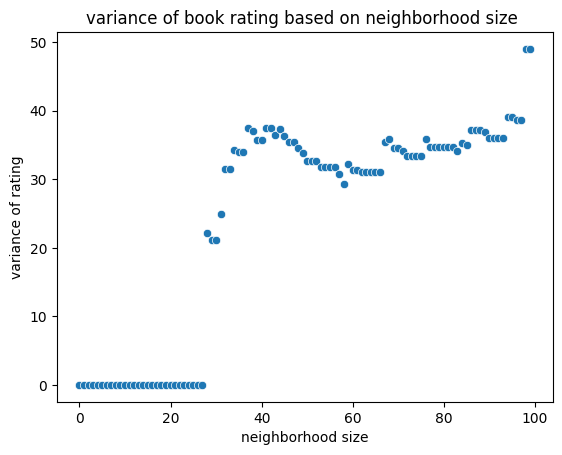

In [89]:
i = np.arange(0,100,1)
ee = np.array(ee)
sns.scatterplot(x = i, y = ee)
plt.title('variance of book rating based on neighborhood size ')
plt.xlabel('neighborhood size')
plt.ylabel('variance of rating')

Based on homogeneity across neighborhood size, we make a call regarding neighborhood size

In [90]:
# find the book list that top1 rator has not read before
circle20_book_list = top1_circle20['ISBN'].unique()
top1_book_list = top1_circle20[top1_circle20['User-ID'] == top1_neighbor.head(1)['User-ID'][0]]['ISBN'].unique()
top1_non_read_list = set(circle20_book_list) - set(top1_book_list)
top1_non_read_list = pd.DataFrame(top1_non_read_list).rename(columns = {0:'ISBN'})

In [91]:
top1_non_read_circle_onebook_rating = top1_circle20[top1_circle20['ISBN'] == top1_non_read_list.iloc[2,0]]
top1_non_read_circle_onebook_rating.head(3)

,index,User-ID,Count,dis,ISBN,Book-Rating,Location,Age
20271,28431,148744,1535,0.072464,0449221113,0,"campbellsport, wisconsin, usa",67.0


In [92]:
top1_non_read_list['recommended_rating'] = 0
top1_non_read_list['recommended_rating_weightedvote'] = 0
top1_non_read_list['recommended_rating_vote'] = 0

for i in range(len(top1_non_read_list)):
    top1_non_read_circle_onebook_rating = top1_circle20[top1_circle20['ISBN'] == top1_non_read_list.iloc[i,0]]
    recommended = top1_non_read_circle_onebook_rating.groupby('Book-Rating')['dis'].agg(['sum','count']).reset_index().sort_values(by = 'sum', ascending = False)
    recommanded_rating = recommended.iloc[0,0]
    recommended_sum = recommended.iloc[0,1]
    recommended_count = recommended.iloc[0,2]
    
    top1_non_read_list.iloc[i,1]=recommanded_rating
    top1_non_read_list.iloc[i,2]=recommended_sum
    top1_non_read_list.iloc[i,3]=recommended_count



In [93]:
# propose the final recommended book, with highest rating and more than 1 
top1_non_read_list_sorted = top1_non_read_list.sort_values(by='recommended_rating',ascending = False)
final_recommend_book = top1_non_read_list_sorted[top1_non_read_list_sorted['recommended_rating_vote']>0.05*20].head(5)

pd.merge(final_recommend_book,df_book,on= 'ISBN',how='left')[['recommended_rating','ISBN','Book-Title','Book-Author','Year-Of-Publication']]

,recommended_rating,ISBN,Book-Title,Book-Author,Year-Of-Publication
0,10,0679781587,NaN,NaN,NaN
1,9,1558745432,A 5th Portion of Chicken Soup for the Soul : 1...,Jack Canfield,1998
2,9,0399501487,Lord of the Flies,William Gerald Golding,1959
3,8,068484477X,STONES FROM THE RIVER,Ursula Hegi,1997
4,7,0679448594,Primary Colors: A Novel of Politics,Anonymous,1996


# 4. Apply KNN model to overall population

In [222]:
tt = df_overall_vf.groupby('User-ID')['Age'].count().reset_index().rename(columns = {"Age":"Count"}).sort_values(by='Count',ascending = False).head(500)
df_top_rator = pd.merge(tt,df_user_knn_v1,on = 'User-ID',how = 'left')
df_top_rator_knn = df_top_rator.drop(columns = ['User-ID','Count'])

distance_matrix = pairwise_distances(df_top_rator_knn, metric='euclidean')
df_distance = pd.DataFrame(distance_matrix)
tt1 = tt.reset_index()
top_rator_distance = pd.concat([tt1,df_distance],axis = 1)
aa = []

for i in range(10):
    top1_distance = top_rator_distance[top_rator_distance['User-ID']==top_rator_distance['User-ID'][i]]
    td  = top1_distance.loc[:,0:]
    td_transpose = td.transpose().rename(columns = {i:"dis"}).sort_values(by='dis',ascending = True)
    top1_dis =pd.concat([tt1,td_transpose],axis = 1)
    td_transpose_sort = top1_dis.sort_values(by = 'dis',ascending = True)

    top1_neighbor = pd.merge(td_transpose_sort,df_user,on = 'User-ID', how = 'left')
    top1_neighbor_rating = pd.merge(td_transpose_sort,df_rating_user,on = 'User-ID', how = 'left')

    #identify cloest neighborhood
    top1_circle20 = top1_neighbor_rating[top1_neighbor_rating['User-ID'].isin(top1_neighbor.head(20)['User-ID'])]
    circle20_book_list = top1_circle20['ISBN'].unique()
    
    #identify books have not been read by the individual
    top1_book_list = top1_circle20[top1_circle20['User-ID'] == top1_neighbor.head(1)['User-ID'][0]]['ISBN'].unique()
    top1_non_read_list = set(circle20_book_list) - set(top1_book_list)
    top1_non_read_list = pd.DataFrame(top1_non_read_list).rename(columns = {0:'ISBN'})

    #create a recommended rating for all unread books
    top1_non_read_list['recommended_rating'] = 0
    top1_non_read_list['recommended_rating_weightedvote'] = 0
    top1_non_read_list['recommended_rating_vote'] = 0

    for i in range(len(top1_non_read_list)):
        top1_non_read_circle_onebook_rating = top1_circle20[top1_circle20['ISBN'] == top1_non_read_list.iloc[i,0]]
        recommended = top1_non_read_circle_onebook_rating.groupby('Book-Rating')['dis'].agg(['sum','count']).reset_index().sort_values(by = 'sum', ascending = False)
        recommanded_rating = recommended.iloc[0,0]
        recommended_sum = recommended.iloc[0,1]
        recommended_count = recommended.iloc[0,2]
    
        top1_non_read_list.iloc[i,1]=recommanded_rating
        top1_non_read_list.iloc[i,2]=recommended_sum
        top1_non_read_list.iloc[i,3]=recommended_count

    #only recommend the ones with highest rating and with enough votes above threshold
    top1_non_read_list_sorted = top1_non_read_list.sort_values(by='recommended_rating',ascending = False)
    final_recommend_book = top1_non_read_list_sorted[top1_non_read_list_sorted['recommended_rating_vote']>0.05*20].head(5)
    recommended_books = pd.merge(final_recommend_book,df_book,on= 'ISBN',how='left')[['recommended_rating','ISBN','Book-Title','Book-Author','Year-Of-Publication']]
    aa.append(recommended_books)

for i in range(10):
   aa[i]['id'] = df_top_rator['User-ID'][i]

In [226]:
# User enters a User-ID, and function will return a list of recommended book

User-ID = 76352

def book_recommendation (ID): 
    index = df_top_rator[df_top_rator['User-ID']==ID].index.tolist()[0]
    return aa[index]

book_recommendation(User-ID)

,recommended_rating,ISBN,Book-Title,Book-Author,Year-Of-Publication,id
0,10,0380018179,The Thorn Birds,Colleen McCullough,1978,76352
1,9,0140053204,Travels With Charley: In Search of America,John Steinbeck,1980,76352
2,0,0061091790,After All These Years,Susan Isaacs,1994,76352
3,0,0671527932,"The LIGHT YEARS (Cazalet Chronicle, Vol 1)",Elizabeth Jane Howard,1995,76352
4,0,0440208912,Harvest,BELVA PLAIN,1991,76352


# Word2vec e-commerce recommendation

In [ ]:
import polars as pl
import pandas as pd
from gensim.models import Word2Vec

In [ ]:
train = pl.read_parquet('/kaggle/input/otto-full-optimized-memory-footprint/train.parquet')
test = pl.read_parquet('/kaggle/input/otto-full-optimized-memory-footprint/test.parquet')

In [ ]:
train.glimpse, test.glimpse

## Problem Phrasing
This problem is to design of a recommendation system based on each session. An session can be considered as a sequence of consecutive action taken by one customer based on a specific initiation reason. 'type' is category of action, '0' represents 'click', '1' is considered as 'add the item to cart', and '2' is as 'order the item'. 'aid' and 'ts' are the the corresponding page and timestamp. The goal of this problem is to predict potential pages related to each type of action, and use the prediction as recommendation.
[Refer to competition page for evaluation metrics](https://www.kaggle.com/c/otto-recommender-system)

## Proposal
We plan to conduct the following steps to derive prediction: 
1. Create a word_list for each session, based on the combination of aid and type, the sequence of 'word' is based on timestamp
2. Fit the word_list to word2vec, to calculat the simiarity among the 'word'
3. Refine sessions to fit into word2vec model, in order to acheive higher performance

In [97]:
all = pl.concat([train, test])
all.glimpse

<bound method DataFrame.glimpse of shape: (223_644_219, 4)
┌──────────┬─────────┬────────────┬──────┐
│ session  ┆ aid     ┆ ts         ┆ type │
│ ---      ┆ ---     ┆ ---        ┆ ---  │
│ i32      ┆ i32     ┆ i32        ┆ u8   │
╞══════════╪═════════╪════════════╪══════╡
│ 0        ┆ 1517085 ┆ 1659304800 ┆ 0    │
│ 0        ┆ 1563459 ┆ 1659304904 ┆ 0    │
│ 0        ┆ 1309446 ┆ 1659367439 ┆ 0    │
│ 0        ┆ 16246   ┆ 1659367719 ┆ 0    │
│ 0        ┆ 1781822 ┆ 1659367871 ┆ 0    │
│ …        ┆ …       ┆ …          ┆ …    │
│ 14571577 ┆ 1141710 ┆ 1662328774 ┆ 0    │
│ 14571578 ┆ 519105  ┆ 1662328775 ┆ 0    │
│ 14571579 ┆ 739876  ┆ 1662328775 ┆ 0    │
│ 14571580 ┆ 202353  ┆ 1662328781 ┆ 0    │
│ 14571581 ┆ 1100210 ┆ 1662328791 ┆ 0    │
└──────────┴─────────┴────────────┴──────┘>

In [ ]:
# only select the sessions with type 2 action
sessions_with_type_2 = all.filter(pl.col('type') == 2)['session'].unique()
filtered_df = all.filter(pl.col('session').is_in(sessions_with_type_2))
filtered_df_f = filtered_df.with_columns(pl.concat_str(["aid", "type"], separator="_").alias("word")).group_by("session").agg(pl.col("word").alias("word_list"))
sentences_filtered = filtered_df_f['word_list'].to_list()
filtered_df_f.glimpse

In [ ]:
%%time

w2vec_filter2 = Word2Vec(sentences=sentences_filtered, vector_size=32, min_count=1, workers=4)

w2vec_filter2.save("word2vec_model_filter2.model")

In [96]:
#prepare trainig dataset 
test_data = test['session'].unique()
test_data_df = test.filter(pl.col('session').is_in(test_data))
test_df_f = test_data_df.with_columns(pl.concat_str(["aid", "type"], separator="_").alias("word")).group_by("session").agg(pl.col("word").alias("word_list"))

test_data_series = pl.Series("session", test_data)
ordered_sessions = pl.DataFrame({"session": test_data_series})
test_df_f = ordered_sessions.join(test_df_f,on="session",how="left")

test_sentence = test_df_f['word_list'].to_list()

test_df_f.glimpse

<bound method DataFrame.glimpse of shape: (1_671_803, 2)
┌──────────┬─────────────────────────────────┐
│ session  ┆ word_list                       │
│ ---      ┆ ---                             │
│ i32      ┆ list[str]                       │
╞══════════╪═════════════════════════════════╡
│ 12899779 ┆ ["59625_0"]                     │
│ 12899780 ┆ ["1142000_0", "582732_0", … "1… │
│ 12899781 ┆ ["141736_0", "199008_0", … "91… │
│ 12899782 ┆ ["1669402_0", "1494780_0", … "… │
│ 12899783 ┆ ["255297_0", "1114789_0", … "1… │
│ …        ┆ …                               │
│ 14571577 ┆ ["1141710_0"]                   │
│ 14571578 ┆ ["519105_0"]                    │
│ 14571579 ┆ ["739876_0"]                    │
│ 14571580 ┆ ["202353_0"]                    │
│ 14571581 ┆ ["1100210_0"]                   │
└──────────┴─────────────────────────────────┘>

In [176]:

w2vec_filter2.wv.most_similar(test_df_f['word_list'][0].to_list(), topn = 20)

[('1725382_1', 0.7495152950286865),
 ('783023_0', 0.732080340385437),
 ('1644268_0', 0.7267307043075562),
 ('1161584_2', 0.7160612940788269),
 ('275579_1', 0.7156184315681458),
 ('1229640_0', 0.7141481041908264),
 ('1266645_2', 0.7127344608306885),
 ('1147983_0', 0.7039910554885864),
 ('1644068_1', 0.7024738192558289),
 ('1322339_2', 0.6985568404197693),
 ('1750220_1', 0.6965306401252747),
 ('121708_0', 0.6964083313941956),
 ('1759475_0', 0.6931356191635132),
 ('573191_0', 0.6924557089805603),
 ('1132329_0', 0.6900633573532104),
 ('365082_0', 0.689970850944519),
 ('1291375_0', 0.6892883777618408),
 ('1372686_0', 0.6883121132850647),
 ('1481032_0', 0.6882781982421875),
 ('1449836_1', 0.6877440214157104)]

In [ ]:
#sessions = test['session'].unique()
types = ['clicks', 'carts', 'orders']
session_type_combinations = [f"{session}_{type}" for session in test_data for type in types]

output = pd.DataFrame(session_type_combinations)
len(test_sentence),output.shape

In [99]:
#we noticed that somes word shown in test data file may not be part of word2vec vocabulary, we will first clean up our test data by removing such cases
clean_test_sentence = []

def clean_list(number_list, w2vec_model):
    cleaned_list = []
    for number in number_list:
        if str(number) in w2vec_model.wv:
            cleaned_list.append(str(number))
    return cleaned_list

for sentence in test_sentence:
     cleaned_list = clean_list(sentence,w2vec_filter2)
     clean_test_sentence.append(cleaned_list)

len(clean_test_sentence)

1671803

In [100]:
empty_elements = [elem for elem in clean_test_sentence if not elem]
len(empty_elements)

7023

In [181]:
df = test_df_f.with_columns(pl.Series('clean_word_list',clean_test_sentence))
df.glimpse

<bound method DataFrame.glimpse of shape: (1_671_803, 3)
┌──────────┬─────────────────────────────────┬─────────────────────────────────┐
│ session  ┆ word_list                       ┆ clean_word_list                 │
│ ---      ┆ ---                             ┆ ---                             │
│ i32      ┆ list[str]                       ┆ list[str]                       │
╞══════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 12899779 ┆ ["59625_0"]                     ┆ ["59625_0"]                     │
│ 12899780 ┆ ["1142000_0", "582732_0", … "1… ┆ ["1142000_0", "582732_0", … "1… │
│ 12899781 ┆ ["141736_0", "199008_0", … "91… ┆ ["141736_0", "199008_0", … "91… │
│ 12899782 ┆ ["1669402_0", "1494780_0", … "… ┆ ["1669402_0", "1494780_0", … "… │
│ 12899783 ┆ ["255297_0", "1114789_0", … "1… ┆ ["255297_0", "1114789_0", … "1… │
│ …        ┆ …                               ┆ …                               │
│ 14571577 ┆ ["1141710_0"]                   ┆ ["114

In [188]:
w2vec_filter2.wv.most_similar(df['clean_word_list'][0].to_list(), topn = 20)

[('1725382_1', 0.7495152950286865),
 ('783023_0', 0.732080340385437),
 ('1644268_0', 0.7267307043075562),
 ('1161584_2', 0.7160612940788269),
 ('275579_1', 0.7156184315681458),
 ('1229640_0', 0.7141481041908264),
 ('1266645_2', 0.7127344608306885),
 ('1147983_0', 0.7039910554885864),
 ('1644068_1', 0.7024738192558289),
 ('1322339_2', 0.6985568404197693),
 ('1750220_1', 0.6965306401252747),
 ('121708_0', 0.6964083313941956),
 ('1759475_0', 0.6931356191635132),
 ('573191_0', 0.6924557089805603),
 ('1132329_0', 0.6900633573532104),
 ('365082_0', 0.689970850944519),
 ('1291375_0', 0.6892883777618408),
 ('1372686_0', 0.6883121132850647),
 ('1481032_0', 0.6882781982421875),
 ('1449836_1', 0.6877440214157104)]

In [219]:
test = df[0:5000]
test_data_1 = test_data[0:5000]

In [220]:
types = ['clicks', 'carts', 'orders']
session_type_combinations = [f"{session}_{type}" for session in test_data_1 for type in types]

output = pd.DataFrame(session_type_combinations)
len(test['clean_word_list']),output.shape

(5000, (15000, 1))

In [221]:
def remove_last_two_digits(input_string):
    elements = input_string.split()
    modified_elements = [element[:-2] for element in elements]
    result = ' '.join(modified_elements) 
    return result

labels = []
for i in range(test.shape[0]):
   if test['clean_word_list'][i].to_list():
    similar_items = w2vec_filter2.wv.most_similar(test['clean_word_list'][i].to_list(), topn=20)
    pred = ' '.join(str(item[0]) for item in similar_items)
    output_string = remove_last_two_digits(pred)
    #labels.extend(similar_items * 3)
    labels.append(output_string)
    labels.append(output_string)
    labels.append(output_string)
   else:# Handle the case when the sentence is empty
        labels.append("911336") #to refine later 
        labels.append("911336")
        labels.append("911336")

output['labels'] = labels
output.tail(10)
   

,0,labels
14990,12904775_orders,457759 495753 858559 1379466 656980 274511 642...
14991,12904776_clicks,247240 1852785 151775 38883 96121 386420 15372...
14992,12904776_carts,247240 1852785 151775 38883 96121 386420 15372...
14993,12904776_orders,247240 1852785 151775 38883 96121 386420 15372...
14994,12904777_clicks,1186311 1581401 1223508 1782334 122792 1144524...
14995,12904777_carts,1186311 1581401 1223508 1782334 122792 1144524...
14996,12904777_orders,1186311 1581401 1223508 1782334 122792 1144524...
14997,12904778_clicks,394075 686334 1083838 776270 252433 688193 252...
14998,12904778_carts,394075 686334 1083838 776270 252433 688193 252...
14999,12904778_orders,394075 686334 1083838 776270 252433 688193 252...


In [ ]:
#refine labels for each category, based on action type
#rank order output based on last digit before removing last two digit
# for orders: keep top 5
# for carts: keep top 10
# for clicks: keep top 20


In [293]:
test = df[0:20]
test_data_1 = test_data[0:20]

types = ['clicks', 'carts', 'orders']
session_type_combinations = [f"{session}_{type}" for session in test_data_1 for type in types]

output = pd.DataFrame(session_type_combinations)
len(test['clean_word_list']),output.shape

(20, (60, 1))

In [294]:
def rank_words(word_list):
  return sorted(word_list, key=lambda word: int(word[-1]), reverse=True)

labels = []
raw = []
origin = []
for i in range(test.shape[0]):
   if test['clean_word_list'][i].to_list():
    similar_items = w2vec_filter2.wv.most_similar(test['clean_word_list'][i].to_list(), topn=30)
    pred = ' '.join(str(item[0]) for item in similar_items)
    pred_1 = pred.split(' ')
    rank_similar_items = rank_words(pred_1)
    pred_clicks = rank_similar_items[:20]
    pred_carts = rank_similar_items[:10]
    pred_orders = rank_similar_items[:5]
    output_string_clicks = [word[:-2] for word in pred_clicks]
    output_string_carts = [word[:-2] for word in pred_carts]
    output_string_orders = [word[:-2] for word in pred_orders]
    #labels.extend(similar_items * 3)
    labels.append(output_string_clicks)
    labels.append(output_string_carts)
    labels.append(output_string_orders)
    raw.append(pred_clicks)
    raw.append(pred_clicks)
    raw.append(pred_clicks)
    origin.append(similar_items)
    origin.append(similar_items)
    origin.append(similar_items)
   else:# Handle the case when the sentence is empty
        labels.append("911336") #to refine later 
        labels.append("911336")
        labels.append("911336")

output['labels'] = labels
output['raw'] = raw
output['origin'] = origin
output = output.rename(columns = {0:'session'})
output.head(10)

,session,labels,raw,origin
0,12899779_clicks,"[1161584, 1266645, 1322339, 938616, 1725382, 2...","[1161584_2, 1266645_2, 1322339_2, 938616_2, 17...","[(1725382_1, 0.7495152950286865), (783023_0, 0..."
1,12899779_carts,"[1161584, 1266645, 1322339, 938616, 1725382, 2...","[1161584_2, 1266645_2, 1322339_2, 938616_2, 17...","[(1725382_1, 0.7495152950286865), (783023_0, 0..."
2,12899779_orders,"[1161584, 1266645, 1322339, 938616, 1725382]","[1161584_2, 1266645_2, 1322339_2, 938616_2, 17...","[(1725382_1, 0.7495152950286865), (783023_0, 0..."
3,12899780_clicks,"[753231, 582732, 1515511, 889686, 932551, 1493...","[753231_2, 582732_1, 1515511_0, 889686_0, 9325...","[(1515511_0, 0.9445929527282715), (889686_0, 0..."
4,12899780_carts,"[753231, 582732, 1515511, 889686, 932551, 1493...","[753231_2, 582732_1, 1515511_0, 889686_0, 9325...","[(1515511_0, 0.9445929527282715), (889686_0, 0..."
5,12899780_orders,"[753231, 582732, 1515511, 889686, 932551]","[753231_2, 582732_1, 1515511_0, 889686_0, 9325...","[(1515511_0, 0.9445929527282715), (889686_0, 0..."
6,12899781_clicks,"[1053786, 1192169, 1672350, 1528283, 604863, 5...","[1053786_1, 1192169_1, 1672350_1, 1528283_0, 6...","[(1528283_0, 0.9793928861618042), (604863_0, 0..."
7,12899781_carts,"[1053786, 1192169, 1672350, 1528283, 604863, 5...","[1053786_1, 1192169_1, 1672350_1, 1528283_0, 6...","[(1528283_0, 0.9793928861618042), (604863_0, 0..."
8,12899781_orders,"[1053786, 1192169, 1672350, 1528283, 604863]","[1053786_1, 1192169_1, 1672350_1, 1528283_0, 6...","[(1528283_0, 0.9793928861618042), (604863_0, 0..."
9,12899782_clicks,"[1152721, 319967, 1000446, 1442118, 77382, 117...","[1152721_2, 319967_1, 1000446_1, 1442118_1, 77...","[(319967_1, 0.952362060546875), (1000446_1, 0...."
